In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import grangercausalitytests
from arch.unitroot import ADF, PhillipsPerron, KPSS
from sklearn.metrics import confusion_matrix
import warnings
# we ignore deprecation warnings and futurewarnings for cleaner output
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Exercise 3.1

* Import the data set with the necessary variables saved in Exercises 2. 
* apply quantile regression for the median (quantile = 0.5) in a full sample
* apply rolling quantile regression for the median (quantile = 0.5) with a window of selected size. Do NOT do it every minute
* plot the rolling estimates of the slope coefficient with a reference line of the full-sample estimate

In [3]:
dataUSA_KO_PEP = pd.read_pickle(r"C:\Me\IQF-3rd semester\HFD\HFD_HW&Project\HW3\dataUSA_KO_PEP.pkl")

In [17]:
dataUSA_KO_PEP.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72540 entries, 2025-01-02 09:31:00 to 2025-09-30 16:00:00
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   close_KO                     72540 non-null  float64
 1   close_PEP                    72540 non-null  float64
 2   r_KO                         72539 non-null  float64
 3   r_PEP                        72539 non-null  float64
 4   r_diff                       72539 non-null  float64
 5   r_diff_rolling_std_bt        72390 non-null  float64
 6   rollcorr90_return_KO_PEP_pl  72450 non-null  float64
dtypes: float64(7)
memory usage: 6.4 MB


In [18]:
dataUSA_KO_PEP.head()

,close_KO,close_PEP,r_KO,r_PEP,r_diff,r_diff_rolling_std_bt,rollcorr90_return_KO_PEP_pl
timestamp,,,,,,,
2025-01-02 09:31:00,61.6987,150.0814,NaN,NaN,NaN,NaN,NaN
2025-01-02 09:32:00,61.6198,149.8123,-12.796135,-17.946364,5.150228,NaN,NaN
2025-01-02 09:33:00,61.6297,149.8123,1.606497,0.000000,1.606497,NaN,NaN
2025-01-02 09:34:00,61.6100,149.9006,-3.197022,5.892306,-9.089328,NaN,NaN
2025-01-02 09:35:00,61.6642,149.9251,8.793406,1.634283,7.159123,NaN,NaN


In [19]:
dataUSA_KO_PEP = dataUSA_KO_PEP.iloc[1:, :]

In [21]:
def efficient_rolling_quantile_regression(y, X, window=180, step=30):
    """
    Rolling quantile regression to avoid calculating at every minute
    
    Parameters:
    y: dependent variable (r_PEP)
    X: independent variable with constant (r_KO with const)
    window: window size (180 minutes)
    step: step size (30 minutes = calculate every 30 minutes)
    """
    dates = []
    const_coefs = []
    beta_coefs = []
    pseudo_rsq = []
    
    # Use step size to avoid calculating every minute
    for i in range(window-1, len(y), step):
        # Extract window data
        y_window = y.iloc[i-window+1:i+1]
        X_window = X.iloc[i-window+1:i+1]
        
        try:
            # Perform quantile regression
            # Note: X already has constant from sm.add_constant()
            model = sm.QuantReg(y_window, X_window)
            result = model.fit(q=0.5)
            
            dates.append(y.index[i])
            const_coefs.append(result.params.iloc[0])  # intercept
            beta_coefs.append(result.params.iloc[1])   # r_KO coefficient
            pseudo_rsq.append(result.prsquared)
        except Exception as e:
            dates.append(y.index[i])
            const_coefs.append(np.nan)
            beta_coefs.append(np.nan)
            pseudo_rsq.append(np.nan)
    
    # Create results DataFrame
    results = pd.DataFrame({
        'const': const_coefs,
        'r_KO_coef': beta_coefs,
        'pseudo_rsquared': pseudo_rsq
    }, index=dates)
    
    return results

Full-sample median quantile regression results:
                         QuantReg Regression Results                          
Dep. Variable:                  r_PEP   Pseudo R-squared:               0.2052
Model:                       QuantReg   Bandwidth:                      0.3871
Method:                 Least Squares   Sparsity:                        7.853
Date:                Tue, 04 Nov 2025   No. Observations:                72539
Time:                        09:22:25   Df Residuals:                    72537
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.362e-07      0.015  -9.34e-06      1.000      -0.029       0.029
r_KO           0.7171      0.002    298.773      0.000       0.712       0.722


c:\Users\hp\.conda\envs\myenv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\hp\.conda\envs\myenv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\hp\.conda\envs\myenv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\hp\.conda\envs\myenv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\hp\.conda\envs\myenv\Lib\site-packages\statsmodels\regr

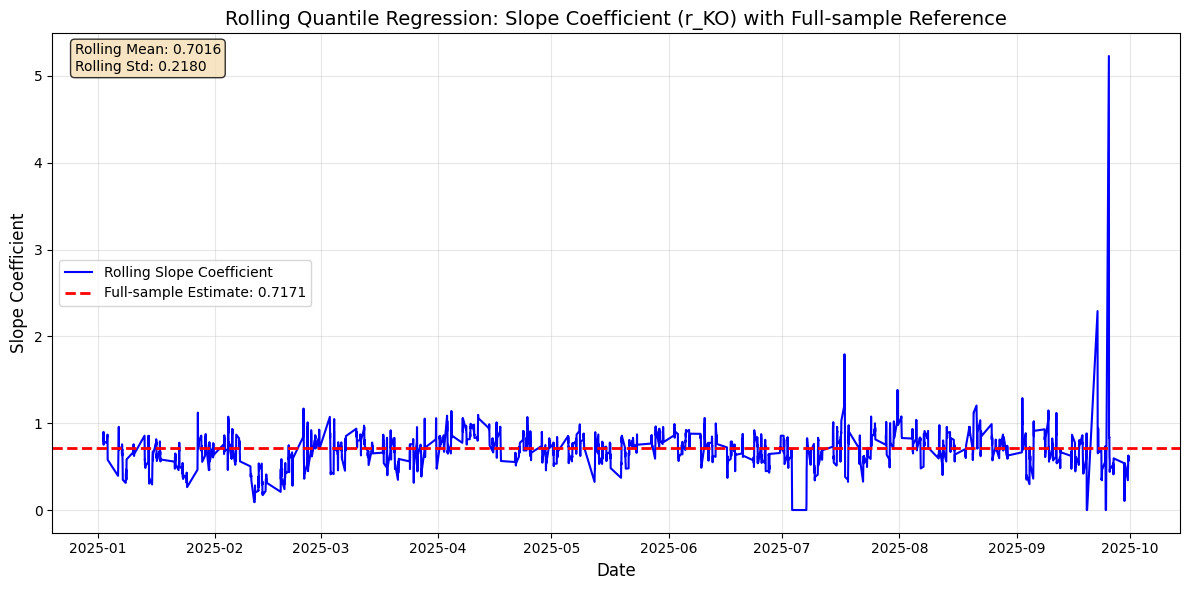


Comparison Statistics:
Full-sample coefficient: 0.717066
Rolling coefficients - Mean: 0.701602
Rolling coefficients - Std:  0.217988
Difference: -0.015464


In [ ]:
# First, get the full-sample quantile regression estimate for reference
X = dataUSA_KO_PEP["r_KO"]
y = dataUSA_KO_PEP["r_PEP"]
X_const = sm.add_constant(X)

# Full-sample median quantile regression
model_qr_median = sm.QuantReg(y, X_const).fit(q=0.5)
full_sample_coef = model_qr_median.params['r_KO']
print("Full-sample median quantile regression results:")
print(model_qr_median.summary())

# Perform rolling quantile regression
rolling_quantile_out = efficient_rolling_quantile_regression(
    y, X_const, window=180, step=30
)

# Plot rolling estimates with full-sample reference line
plt.figure(figsize=(12, 6))

# Plot rolling slope coefficients
plt.plot(rolling_quantile_out.index, rolling_quantile_out['r_KO_coef'], 
         linewidth=1.5, label='Rolling Slope Coefficient', color='blue')

# Add full-sample reference line
plt.axhline(y=full_sample_coef, color='red', linestyle='--', 
            linewidth=2, label=f'Full-sample Estimate: {full_sample_coef:.4f}')

# Customize the plot
plt.title('Rolling Quantile Regression: Slope Coefficient (r_KO) with Full-sample Reference', fontsize=14)
plt.ylabel('Slope Coefficient', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add some statistics to the plot
mean_rolling = rolling_quantile_out['r_KO_coef'].mean()
std_rolling = rolling_quantile_out['r_KO_coef'].std()

plt.text(0.02, 0.98, f'Rolling Mean: {mean_rolling:.4f}\nRolling Std: {std_rolling:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\nComparison Statistics:")
print(f"Full-sample coefficient: {full_sample_coef:.6f}")
print(f"Rolling coefficients - Mean: {mean_rolling:.6f}")
print(f"Rolling coefficients - Std:  {std_rolling:.6f}")
print(f"Difference: {mean_rolling - full_sample_coef:.6f}")

# Exercise 3.2

* test for Granger causality in both directions within a window of selected size. Do NOT do it every minute
* compute the proportion of causality findings at 5% significance level in both directions
* check with a contingency table how many times we have both rejections, none or only one-sided rejection

In [23]:
def safe_granger_pvalue(df: pd.DataFrame, col1: str, col2: str, maxlag: int) -> float:
    """Robust Granger causality test with comprehensive checks"""
    try:
        # Extract the window data
        data = df[[col1, col2]].dropna()
        
        # Check data requirements
        if len(data) < maxlag * 2 + 5:
            return 1.0
        
        # Check for constant values
        if data[col1].nunique() == 1 or data[col2].nunique() == 1:
            return 1.0
        
        # Check for sufficient variance
        if data[col1].std() < 1e-10 or data[col2].std() < 1e-10:
            return 1.0
        
        # Perform Granger test
        granger_test = grangercausalitytests(data[[col2, col1]], maxlag=[maxlag], 
                                           verbose=False)
        p_value = granger_test[maxlag][0]['ssr_ftest'][1]
        return float(p_value)
        
    except Exception as e:
        # Return non-significant p-value for any error
        return 1.0

In [24]:
df_K_P = dataUSA_KO_PEP[["close_KO", "close_PEP"]]

In [25]:
_granger1 = lambda x: safe_granger_pvalue(df_K_P.loc[x.index], 
                                        "close_KO", "close_PEP", maxlag=10)

_granger2 = lambda x: safe_granger_pvalue(df_K_P.loc[x.index], 
                                        "close_PEP", "close_KO", maxlag=10)

granger_pvalues_AAPL_to_META = df_K_P["close_KO"].rolling(window = 90, 
                                                            step = 15).apply(_granger1)
granger_pvalues_META_to_AAPL = df_K_P["close_PEP"].rolling(window = 90,
                                                            step = 15).apply(_granger2)

granger_pvalues = pd.concat([granger_pvalues_META_to_AAPL.rename("p_value_PEP_to_KO"),
                             granger_pvalues_AAPL_to_META.rename("p_value_KO_to_PEP")],
                             axis=1).dropna()
granger_pvalues.head()

,p_value_PEP_to_KO,p_value_KO_to_PEP
timestamp,,
2025-01-02 11:02:00,0.747622,0.052291
2025-01-02 11:17:00,0.416722,0.162126
2025-01-02 11:32:00,0.430459,0.165301
2025-01-02 11:47:00,0.506308,0.051616
2025-01-02 12:02:00,0.600851,0.001275


In [26]:
# Compute proportion of causality findings at 5% significance level
def compute_causality_proportions(pvalues_df):
    """Compute proportions of significant causality findings at 5% level"""
    
    # Remove rows with NaN values
    clean_df = pvalues_df.dropna()
    total_tests = len(clean_df)
    
    # Count significant rejections at 5% level
    ko_to_pep_reject = (clean_df['p_value_KO_to_PEP'] < 0.05).sum()
    pep_to_ko_reject = (clean_df['p_value_PEP_to_KO'] < 0.05).sum()
    
    # Calculate proportions
    prop_ko_to_pep = ko_to_pep_reject / total_tests
    prop_pep_to_ko = pep_to_ko_reject / total_tests

    print(f"Total number of tests: {total_tests}")
    print(f"KO → PEP causality: {ko_to_pep_reject}/{total_tests} = {prop_ko_to_pep:.4f} ({prop_ko_to_pep*100:.2f}%)")
    print(f"PEP → KO causality: {pep_to_ko_reject}/{total_tests} = {prop_pep_to_ko:.4f} ({prop_pep_to_ko*100:.2f}%)")
    
    return prop_ko_to_pep, prop_pep_to_ko, clean_df

# Compute proportions
prop_ko_pep, prop_pep_ko, clean_pvalues = compute_causality_proportions(granger_pvalues)

Total number of tests: 4830
KO → PEP causality: 783/4830 = 0.1621 (16.21%)
PEP → KO causality: 747/4830 = 0.1547 (15.47%)


In [27]:
# Create the exact contingency table 
def create_formatted_contingency_table(pvalues_df):
    """Create contingency table in the specified format"""
    
    # Remove rows with NaN values
    clean_df = pvalues_df.dropna()
    
    # Create binary rejection indicators
    ko_pep_reject = clean_df['p_value_KO_to_PEP'] < 0.05  # KO causes PEP
    pep_ko_reject = clean_df['p_value_PEP_to_KO'] < 0.05  # PEP causes KO
    
    # Count different rejection patterns
    neither_reject = (~pep_ko_reject & ~ko_pep_reject).sum()  # PEP does NOT cause KO & KO does NOT cause PEP
    ko_only_reject = (~pep_ko_reject & ko_pep_reject).sum()   # PEP does NOT cause KO & KO causes PEP  
    pep_only_reject = (pep_ko_reject & ~ko_pep_reject).sum()  # PEP causes KO & KO does NOT cause PEP
    both_reject = (pep_ko_reject & ko_pep_reject).sum()       # PEP causes KO & KO causes PEP
    
    total = neither_reject + ko_only_reject + pep_only_reject + both_reject
    
    # Calculate proportions
    prop_neither = neither_reject / total
    prop_ko_only = ko_only_reject / total
    prop_pep_only = pep_only_reject / total
    prop_both = both_reject / total
    
    # Create the contingency table in the exact format
    contingency_data = [
        [prop_neither, prop_ko_only],    # PEP does NOT cause KO row
        [prop_pep_only, prop_both]       # PEP causes KO row
    ]
    
    contingency_table = pd.DataFrame(
        contingency_data,
        index=['PEP does NOT cause KO', 'PEP causes KO'],
        columns=['KO does NOT cause PEP', 'KO causes PEP']
    )
    
    # Format for display (6 decimal places)
    display_table = contingency_table.copy()
    for col in display_table.columns:
        display_table[col] = display_table[col].apply(lambda x: f"{x:.6f}")
    
    print("Contingency table of results of Granger causality tests:")
    print(" " * 30 + "KO does NOT cause PEP".ljust(25) + "KO causes PEP")
    
    print("PEP does NOT cause KO".ljust(30) + 
          f"{prop_neither:.6f}".ljust(25) + 
          f"{prop_ko_only:.6f}")
    
    print("PEP causes KO".ljust(30) + 
          f"{prop_pep_only:.6f}".ljust(25) + 
          f"{prop_both:.6f}")
    
    return contingency_table

# Create the formatted contingency table
formatted_contingency = create_formatted_contingency_table(granger_pvalues)

Contingency table of results of Granger causality tests:
                              KO does NOT cause PEP    KO causes PEP
PEP does NOT cause KO         0.740166                 0.105176
PEP causes KO                 0.097723                 0.056936


# Exercise 3.3

* test for cointegration (ADF, PP, KPSS) in the full sample - interpret the results
* test for cointegration (ADF, PP, KPSS) within a rolling window of selected size. Do NOT do it every minute
* plot the p-values of the tests within the rolling window
* check how often the cointegration is found at 5% significance level for each test

In [28]:
# Step 1: estimate the long-run relationship with OLS
X_price = dataUSA_KO_PEP["close_KO"]
y_price = dataUSA_KO_PEP["close_PEP"]
X_price = sm.add_constant(X_price)  # adding a constant term for intercept

model_ols_price = sm.OLS(y_price, X_price).fit()
print(model_ols_price.summary())

                            OLS Regression Results                            
Dep. Variable:              close_PEP   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     7889.
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:24:39   Log-Likelihood:            -2.4297e+05
No. Observations:               72539   AIC:                         4.859e+05
Df Residuals:                   72537   BIC:                         4.860e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        189.6440      0.553    342.706      0.0

In [5]:
# Step 2: obtain the residuals from the OLS regression
residuals = model_ols_price.resid

In [ ]:
# and test them for stationarity with the ADF test
adf_test = ADF(residuals)
print(adf_test.summary().as_text())

# We cannot reject H0 about NON-stationarity

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.403
P-value                         0.141
Lags                               63
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [ ]:
# Apply PP test
pp_test = PhillipsPerron(residuals) 
print(pp_test.summary().as_text())

# we cannot reject H0 about NON-stationarity

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.424
P-value                         0.135
Lags                               63
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [ ]:
# Apply KPSS test
kpss_test = KPSS(residuals)
print(kpss_test.summary().as_text())

# we reject H0 about stationarity

    KPSS Stationarity Test Results   
Test Statistic                  5.697
P-value                         0.000
Lags                              161
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [9]:
def _eg_residuals(df: pd.DataFrame, col1: str, col2: str):
    X = sm.add_constant(df[col1].values, has_constant="add")
    y = df[col2].values
    model = sm.OLS(y, X).fit()
    return model.resid

# the function for ADF p-value
def eg_adf_pvalue(df: pd.DataFrame, col1: str, col2: str, 
                  trend: str = "c", adf_lags: int = 5) -> float:
    resid = _eg_residuals(df, col1, col2)
    return float(ADF(resid, lags=adf_lags, trend=trend).pvalue)

# the function for PP p-value
def eg_pp_pvalue(df: pd.DataFrame, col1: str, col2: str, 
                 trend: str = "c") -> float:
    resid = _eg_residuals(df, col1, col2)
    return float(PhillipsPerron(resid, trend=trend).pvalue)

# the function for KPSS p-value
def eg_kpss_pvalue(df: pd.DataFrame, col1: str, col2: str, 
                   trend: str = "c") -> float:
    resid = _eg_residuals(df, col1, col2)
    return float(KPSS(resid, trend=trend).pvalue)

In [11]:
_adf = lambda x: eg_adf_pvalue(df_K_P.loc[x.index], 
                               "close_KO", "close_PEP")
_pp  = lambda x: eg_pp_pvalue(df_K_P.loc[x.index], 
                              "close_KO", "close_PEP")
_kpss= lambda x: eg_kpss_pvalue(df_K_P.loc[x.index], 
                                "close_KO", "close_PEP")

# we apply the test every 60 minutes on a 240 minute window
adf_p = df_K_P["close_PEP"].rolling(window = 240, 
                                     step = 60).apply(_adf)
pp_p  = df_K_P["close_PEP"].rolling(window = 240, 
                                     step = 60).apply(_pp)
kpss_p= df_K_P["close_PEP"].rolling(window = 240, 
                                     step = 60).apply(_kpss)

out = pd.concat({"adf_p": adf_p, "pp_p": pp_p, "kpss_p": kpss_p}, axis=1).dropna()

out.head()

,adf_p,pp_p,kpss_p
timestamp,,,
2025-01-02 13:31:00,0.001370,0.000025,0.502523
2025-01-02 14:31:00,0.278268,0.057889,0.039788
2025-01-02 15:31:00,0.929778,0.715559,0.000386
2025-01-03 10:01:00,0.360706,0.467346,0.000100
2025-01-03 11:01:00,0.064360,0.007280,0.122514


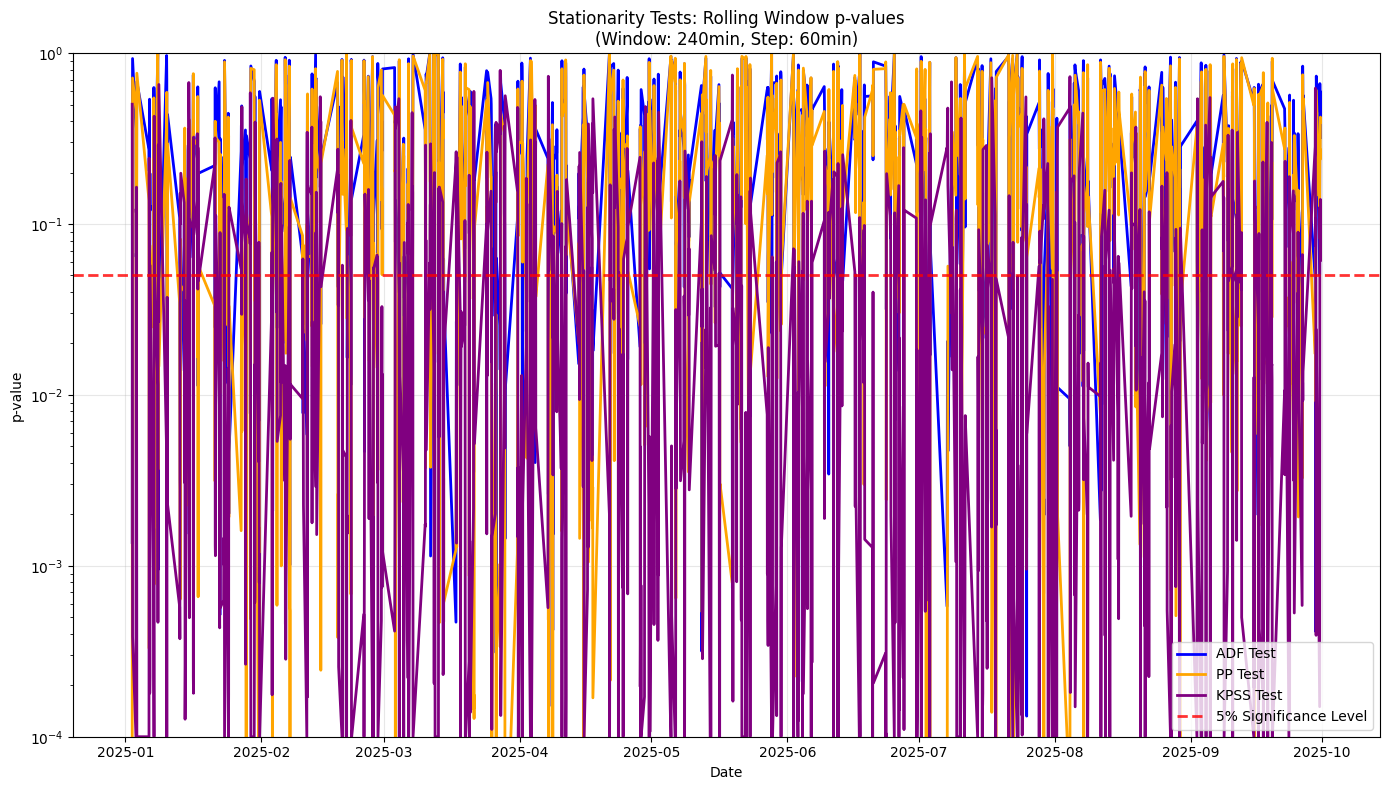

In [12]:
# Combined plot with all three tests
plt.figure(figsize=(14, 8))

plt.plot(out.index, out['adf_p'], linewidth=2, label='ADF Test', color='blue')
plt.plot(out.index, out['pp_p'], linewidth=2, label='PP Test', color='orange')
plt.plot(out.index, out['kpss_p'], linewidth=2, label='KPSS Test', color='purple')

plt.axhline(y=0.05, color='red', linestyle='--', linewidth=2, 
            label='5% Significance Level', alpha=0.8)

plt.ylabel('p-value')
plt.xlabel('Date')
plt.title('Stationarity Tests: Rolling Window p-values\n(Window: 240min, Step: 60min)')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.ylim(1e-4, 1)

plt.tight_layout()
plt.show()

In [13]:
print("Share of times cointegration identified at 5% significance level:")
print("ADF test:", (out["adf_p"] < 0.05).sum()/out.size)
print("PP test:", (out["pp_p"] < 0.05).sum()/out.size)
# IMPORTANT - in KPSS H0 is about stationarity
print("KPSS test:", (out["kpss_p"] > 0.05).sum()/out.size)

Share of times cointegration identified at 5% significance level:
ADF test: 0.07441217150760719
PP test: 0.11286307053941909
KPSS test: 0.13167358229598894


# Exercise 3.4 *

The Granger causality test is performed based on a linear regression model:

$$y_t = \alpha_0 + \sum_{i=1}^{p} \alpha_i y_{t-i} + \sum_{j=1}^{p} \beta_j x_{t-j} + \epsilon_t$$

The null hypothesis is that the coefficients $\beta_i$ are jointly equal to zero:

$$H_0: \beta_1 = \beta_2 = ... = \beta_p = 0$$

 If we reject the null hypothesis, we conclude that $x$ Granger-causes $y$.

It is tested with an F-test based on the sum of squared residuals from the unrestricted model (with lags $x$ included) and the restricted model (without lags of $x$).

$$F = \frac{(SSR_{R} - SSR_{UR})/p}{SSR_{U}/(n - 2p - 1)}$$

where $SSR_{R}$ is the sum of squared residuals from the restricted model (when the null hypothesis is true), $SSR_{U}$ is the sum of squared residuals from the unrestricted (full) model, $p$ is the number of lags (2p is the total number of regressors), and $n$ is the number of observations.

The results of the rollingOLS function include SSR values, so we can use them to calculate rolling Granger causality p-values more efficiently.

Check the code:
```python
rolling_results.ssr.tail()
```
and write a function that calculates rolling Granger causality p-values based on the SSR values from two rolling OLS results (one for the restricted model and one for the unrestricted model).@

In [29]:
rolling_model = RollingOLS(y, X, window = 180, min_nobs = 180)
rolling_results = rolling_model.fit()

In [30]:
rolling_results.ssr.tail()

timestamp
2025-09-30 15:56:00    1092.206401
2025-09-30 15:57:00    1105.338342
2025-09-30 15:58:00    1097.663655
2025-09-30 15:59:00    1097.715183
2025-09-30 16:00:00    1109.891056
dtype: float64

In [44]:
# Step 1: Create Lagged Variables
def create_lagged_data(data, y_col, x_col, p=5):
    """
    Create lagged variables for Granger causality test.
    
    Parameters:
    -----------
    data : DataFrame
        Input data with y and x columns
    y_col : str
        Name of the dependent variable column
    x_col : str
        Name of the independent variable column
    p : int
        Number of lags
    
    Returns:
    --------
    y : Series
        Dependent variable (aligned with lagged data)
    X_unrestricted : DataFrame
        Features for unrestricted model (y lags + x lags)
    X_restricted : DataFrame
        Features for restricted model (y lags only)
    """
    df = data[[y_col, x_col]].copy()
    
    # Create lagged variables for y
    for i in range(1, p + 1):
        df[f'{y_col}_lag{i}'] = df[y_col].shift(i)
    
    # Create lagged variables for x
    for i in range(1, p + 1):
        df[f'{x_col}_lag{i}'] = df[x_col].shift(i)
    
    # Remove rows with NaN (due to lagging)
    df = df.dropna()
    
    # Prepare y
    y = df[y_col]
    
    # Prepare X for unrestricted model (includes both y and x lags)
    x_unrestricted_cols = [f'{y_col}_lag{i}' for i in range(1, p + 1)] + \
                          [f'{x_col}_lag{i}' for i in range(1, p + 1)]
    X_unrestricted = df[x_unrestricted_cols]
    X_unrestricted = sm.add_constant(X_unrestricted)
    
    # Prepare X for restricted model (includes only y lags)
    x_restricted_cols = [f'{y_col}_lag{i}' for i in range(1, p + 1)]
    X_restricted = df[x_restricted_cols]
    X_restricted = sm.add_constant(X_restricted)
    
    return y, X_unrestricted, X_restricted
# Step 2: Calculate Rolling Granger Causality p-values

def rolling_granger_causality_pvalues(ssr_unrestricted, ssr_restricted, p, n):
    """
    Calculate rolling Granger causality p-values from SSR values.
    
    Parameters:
    -----------
    ssr_unrestricted : Series
        SSR from unrestricted model (with x lags)
    ssr_restricted : Series
        SSR from restricted model (without x lags)
    p : int
        Number of lags
    n : int
        Window size (number of observations in each rolling window)
    
    Returns:
    --------
    pvalues : Series
        Rolling p-values for Granger causality test
    """
    # Align the two SSR series
    aligned_data = pd.DataFrame({
        'ssr_u': ssr_unrestricted,
        'ssr_r': ssr_restricted
    }).dropna()
    
    # Calculate F-statistic
    # F = [(SSR_R - SSR_U) / p] / [SSR_U / (n - 2p - 1)]
    numerator = (aligned_data['ssr_r'] - aligned_data['ssr_u']) / p
    denominator = aligned_data['ssr_u'] / (n - 2 * p - 1)
    
    F_stat = numerator / denominator
    
    # Calculate p-values using F-distribution
    # df1 = p (numerator degrees of freedom)
    # df2 = n - 2p - 1 (denominator degrees of freedom)
    df1 = p
    df2 = n - 2 * p - 1
    
    pvalues = F_stat.apply(lambda f: 1 - stats.f.cdf(f, df1, df2) if f > 0 else np.nan)
    
    return pvalues

# Step 3: Main Analysis

# Parameters
p = 5  # Number of lags (you can change this)
window = 180  # Rolling window size
min_nobs = 180  # Minimum observations required

# Create lagged data
y, X_unrestricted, X_restricted = create_lagged_data(
    dataUSA_KO_PEP, 
    y_col='r_PEP',  # Dependent variable
    x_col='r_KO',   # Independent variable (testing if r_KO Granger-causes r_PEP)
    p=p
)

print(f"y: {y.shape}")
print(f"X_unrestricted: {X_unrestricted.shape}")
print(f"X_restricted: {X_restricted.shape}")

# Run Rolling OLS for unrestricted model
rolling_model_unrestricted = RollingOLS(y, X_unrestricted, window=window, min_nobs=min_nobs)
rolling_results_unrestricted = rolling_model_unrestricted.fit()

# Run Rolling OLS for restricted model
rolling_model_restricted = RollingOLS(y, X_restricted, window=window, min_nobs=min_nobs)
rolling_results_restricted = rolling_model_restricted.fit()

# Calculate rolling Granger causality p-values
granger_pvalues = rolling_granger_causality_pvalues(
    ssr_unrestricted=rolling_results_unrestricted.ssr,
    ssr_restricted=rolling_results_restricted.ssr,
    p=p,
    n=window
)

# Display results
print(f"Null Hypothesis: r_KO does NOT Granger-cause r_PEP")
print(f"Number of lags: {p}")
print(f"Rolling window: {window}")
print(f"\nLast 10 p-values:")
print(granger_pvalues.tail(10))

print(f"\nSummary statistics of p-values:")
print(granger_pvalues.describe())

print(f"\nProportion of windows where null is rejected at 5% level:")
print(f"{(granger_pvalues < 0.05).sum() / len(granger_pvalues):.2%}")


y: (72534,)
X_unrestricted: (72534, 11)
X_restricted: (72534, 6)
Null Hypothesis: r_KO does NOT Granger-cause r_PEP
Number of lags: 5
Rolling window: 180

Last 10 p-values:
timestamp
2025-09-30 15:51:00    0.600525
2025-09-30 15:52:00    0.642910
2025-09-30 15:53:00    0.567434
2025-09-30 15:54:00    0.511829
2025-09-30 15:55:00    0.448155
2025-09-30 15:56:00    0.418637
2025-09-30 15:57:00    0.446188
2025-09-30 15:58:00    0.498580
2025-09-30 15:59:00    0.548307
2025-09-30 16:00:00    0.498486
dtype: float64

Summary statistics of p-values:
count    7.203200e+04
mean     3.403791e-01
std      3.080634e-01
min      1.110223e-16
25%      5.182707e-02
50%      2.564296e-01
75%      5.940764e-01
max      1.000000e+00
dtype: float64

Proportion of windows where null is rejected at 5% level:
24.56%
